Batch Gradient Descent (entire dataset per update)
→ Covered by LogisticRegression (e.g. solver='lbfgs').

Stochastic Gradient Descent (SGD) (1 sample per update)
→ Done via SGDClassifier.

Mini-Batch Gradient Descent (e.g. 64 samples per update)
→ Using SGDClassifier + partial_fit manually.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ---------- Data ----------
data = {
    "pass_id": np.arange(0, 1000),
    "survive": np.random.choice(['yes', 'no'], size=1000),
    "pclass": np.random.choice(['top', 'ave', 'poor'], size=1000),
    "age": np.random.randint(10, 80, size=1000),
    "name": ["Mo_" + str(i) for i in range(0, 1000)],
    "sex": np.random.choice(['M', 'F'], size=1000)
}
df = pd.DataFrame(data)

In [3]:
df.head()

,pass_id,survive,pclass,age,name,sex
0,0,yes,top,73,Mo_0,F
1,1,no,ave,61,Mo_1,M
2,2,yes,poor,28,Mo_2,M
3,3,no,ave,73,Mo_3,M
4,4,yes,ave,71,Mo_4,F


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pass_id  1000 non-null   int32 
 1   survive  1000 non-null   object
 2   pclass   1000 non-null   object
 3   age      1000 non-null   int32 
 4   name     1000 non-null   object
 5   sex      1000 non-null   object
dtypes: int32(2), object(4)
memory usage: 39.2+ KB


In [5]:
df.describe()

,pass_id,age
count,1000.000000,1000.000000
mean,499.500000,43.984000
std,288.819436,20.333844
min,0.000000,10.000000
25%,249.750000,25.000000
50%,499.500000,45.000000
75%,749.250000,61.000000
max,999.000000,79.000000


In [6]:
df.isnull().sum()

pass_id    0
survive    0
pclass     0
age        0
name       0
sex        0
dtype: int64

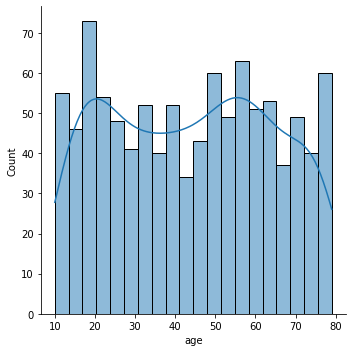

In [10]:
sns.displot(data=df, x='age',kde=True, bins=20)

<AxesSubplot:xlabel='pclass', ylabel='age'>

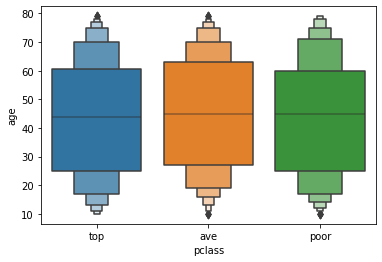

In [11]:
sns.boxenplot(data=df, x='pclass', y='age')

In [12]:
# ---------- Preprocessing ----------
pclass_mapping = {'poor': 0, 'ave': 1, 'top': 2}
df['pclass'] = df['pclass'].map(pclass_mapping)

from sklearn.preprocessing import LabelEncoder
encod_cols = ['sex', 'survive']
for col in encod_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.drop(columns='name', inplace=True)


In [13]:
# ---------- Split ----------
from sklearn.model_selection import train_test_split
x = df.drop('survive', axis=1)
y = df['survive']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# ---------- 1. Batch Gradient Descent (LogisticRegression) ----------
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)
pred_lr = lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)
print("Batch Gradient Descent (LogisticRegression):")
print("Accuracy:", acc_lr)

✅ Batch Gradient Descent (LogisticRegression):
Accuracy: 0.53


In [23]:
# ---------- 2. Stochastic Gradient Descent (SGDClassifier) ----------
from sklearn.linear_model import SGDClassifier

# SGD with multiple epochs, learning rate, and stochastic updates
sgd_model = SGDClassifier(loss='log', penalty='l2', learning_rate='optimal', max_iter=1000, random_state=123)

# This will internally use stochastic updates (1 sample at a time) efficiently
sgd_model.fit(X_train, y_train)

pred_sgd = sgd_model.predict(X_test)
acc_sgd = accuracy_score(y_test, pred_sgd)

print("✅ Stochastic Gradient Descent (SGD - fast version):")
print("Accuracy:", acc_sgd)
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_sgd))
print("Classification Report:\n", classification_report(y_test, pred_sgd))

✅ Stochastic Gradient Descent (SGD - fast version):
Accuracy: 0.525
Confusion Matrix:
 [[  0  95]
 [  0 105]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        95
           1       0.53      1.00      0.69       105

    accuracy                           0.53       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.28      0.53      0.36       200



c:\Users\Mo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# ---------- 3. Mini-Batch Gradient Descent (Custom partial_fit loop) ----------
mini_model = SGDClassifier(loss='log', penalty='l2', learning_rate='optimal', max_iter=1, random_state=123, warm_start=True)
batch_size = 32
for _ in range(100):  # epochs
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train.iloc[i:i+batch_size]
        y_batch = y_train.iloc[i:i+batch_size]
        mini_model.partial_fit(X_batch, y_batch, classes=np.array([0, 1]))
pred_mini = mini_model.predict(X_test)
acc_mini = accuracy_score(y_test, pred_mini)
print("Mini-Batch Gradient Descent (Batch size = 32):")
print("Accuracy:", acc_mini)

Mini-Batch Gradient Descent (Batch size = 32):
Accuracy: 0.48


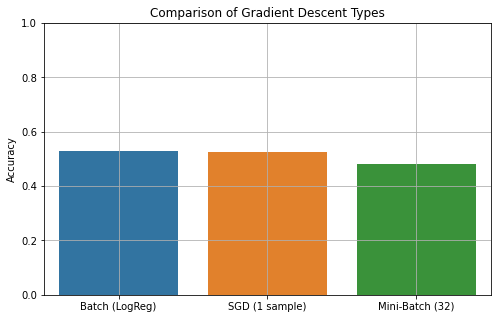

In [25]:
# ---------- Plot Accuracy Comparison ----------
labels = ['Batch (LogReg)', 'SGD (1 sample)', 'Mini-Batch (32)']
accuracies = [acc_lr, acc_sgd, acc_mini]

plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=accuracies)
plt.ylabel('Accuracy')
plt.title('Comparison of Gradient Descent Types')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ---------- 1. Batch Gradient Descent (LogisticRegression) ----------
print("✅ Batch Gradient Descent (LogisticRegression):")
print("Accuracy:", acc_lr)
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_lr))
print("Classification Report:\n", classification_report(y_test, pred_lr))

# ---------- 2. Stochastic Gradient Descent (SGDClassifier) ----------
print("\n✅ Stochastic Gradient Descent (SGD - 1 sample):")
print("Accuracy:", acc_sgd)
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_sgd))
print("Classification Report:\n", classification_report(y_test, pred_sgd))

# ---------- 3. Mini-Batch Gradient Descent (batch size = 32) ----------
print("\n✅ Mini-Batch Gradient Descent (Batch size = 32):")
print("Accuracy:", acc_mini)
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_mini))
print("Classification Report:\n", classification_report(y_test, pred_mini))


✅ Batch Gradient Descent (LogisticRegression):
Accuracy: 0.53
Confusion Matrix:
 [[51 44]
 [50 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.54      0.52        95
           1       0.56      0.52      0.54       105

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200


✅ Stochastic Gradient Descent (SGD - 1 sample):
Accuracy: 0.525
Confusion Matrix:
 [[  0  95]
 [  0 105]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        95
           1       0.53      1.00      0.69       105

    accuracy                           0.53       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.28      0.53      0.36       200


✅ Mini-Batch Gradient Descent (Batch size = 32):
Accuracy: 0.48
Confusion Matrix:
 [[ 94  

c:\Users\Mo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
